## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
    else:
        print('Found no chessboards')

cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Found no chessboards
Found no chessboards
Found no chessboards


Opening: ./camera_cal/calibration1.jpg


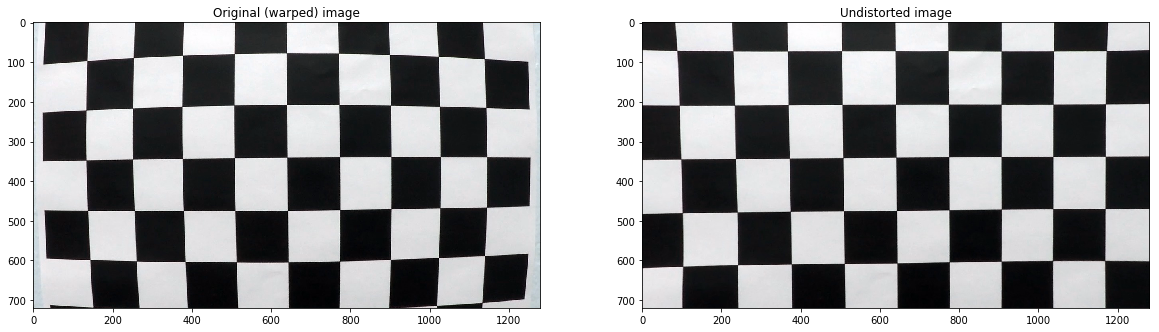

In [3]:
# Undistort one of the images
fname = images[0]
print('Opening: {}'.format(fname))
img = cv2.imread(fname)

undist=cv2.undistort(img,mtx,dist)
cv2.imwrite('output_images/test_undist.jpg',undist)
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original (warped) image')
ax1.imshow(img)
ax2.set_title('Undistorted image')
ax2.imshow(undist)

## And so on and so forth...

In [142]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255), ksize=5):
    """ Compute a thresholded gradient binary image.
    
    This function takes an input image and applies a Sobel filter in the given orientation. 
    It then applies a threshold (min & max) to the computed gradient. It returns a binary image
    where 1's denote pixels whose absolute gradient falls within the threshold.
    
    Args:
        img (numpy array): The color input image.
        orient (string, 'x' or 'y'): Which direction to calculate the gradient.
        thresh (tuple): (min, max) values of the threshold to apply.
        ksize (int): the sobel kernel size
    Returns:
        A binary image where 1s denote pixels whose absolute gradient falls within the threshold.
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        img_sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    else:
        img_sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(img_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    img_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    img_mask = (img_scaled <= thresh[1]) & (img_scaled > thresh[0])
    binary_image = np.zeros_like(img_scaled)
    binary_image[img_mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_image

def mag_thresh(img, ksize=5, mag_thresh=(0, 255)):
    """ Compute the magnitude of the gradient at each pixel and return a binary image.
    
    This function takes the gradients in both x and y of an image and computes
    the overall magnitude of the gradient. It returns a binary image with pixel
    values of 1 wherever the gradient falls between the specified threshold values.
    
    Args:
        img (numpy array): Color input image.
        ksize (int): The Sobel kernel window size to apply. Must be an odd number.
        mag_thresh (tuple): The (min, max)
    Returns:
        A binary image with 1s wherever the magnitude of the gradient falls within the
        threshold bounds, and 0s elsewhere.        
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    grad_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Calculate the magnitude 
    mag_grad = np.sqrt(np.square(grad_x) + np.square(grad_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*mag_grad/np.max(mag_grad))
    # 5) Create a binary mask where mag thresholds are met
    img_mask = (scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])
    binary_output = np.zeros_like(img_gray)
    # 6) Return this mask as your binary_output image
    binary_output[img_mask] = 1
    return binary_output

def dir_thresh(img, ksize=5, thresh=(0, np.pi/2)):
    """Compute the direction of the gradient and return a binary image that satisfies the thresholds.
    
    This function computes the direction of the image gradient at each pixel and applies a threshold
    to it. It returns a binary image with 1s wherever the gradient direction falls within the supplied
    threshold, and 0s elsewhere.
    
    Args:
        img (numpy array): input color image,
        ksize (int): the size of the sobel kernel to apply (must be an odd number).
        thresh (tuple): the minimum and maximum thresholds.
    Returns:
        A binary image with 1s wherever the gradient direction falls within the threshold, 0s elsewhere.
        """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobel_x)
    abs_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    img_mask = (grad_dir <= thresh[1]) & (grad_dir >= thresh[0])
    binary_output = np.zeros_like(grad_dir)
    binary_output[img_mask]=1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_color_threshold(img, h_thresh=(0,255), s_thresh=(0,255)):
    # Convert to HSV color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel
    h_binary = np.zeros_like(s_channel)
    s_binary = np.zeros_like(s_channel)
    binary_out = np.zeros_like(s_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    binary_out[(h_binary==1) & (s_binary==1)]=1
    return binary_out

    

In [143]:
# Edit this function to create your own pipeline.
def pipeline(img):
    # Take a local copy of the image
    img = np.copy(img)
    gradx = abs_sobel_thresh(img, orient='x', thresh=(20,150), ksize=5)
    grady = abs_sobel_thresh(img, orient='y', thresh=(20,150), ksize=5)
    mag_binary = mag_thresh(img, ksize=5, mag_thresh=(30, 150))
    dir_binary = dir_thresh(img, ksize=5, thresh=(0.7,1.3))
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    color_threshold = hls_color_threshold(img, h_thresh=(15,100), s_thresh=(90,255))
    pipeline_out = np.zeros_like(color_threshold)
    pipeline_out[(combined_grad==1)|(color_threshold==1)]=1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    images = np.dstack((combined_grad, color_threshold, pipeline_out))
    return images

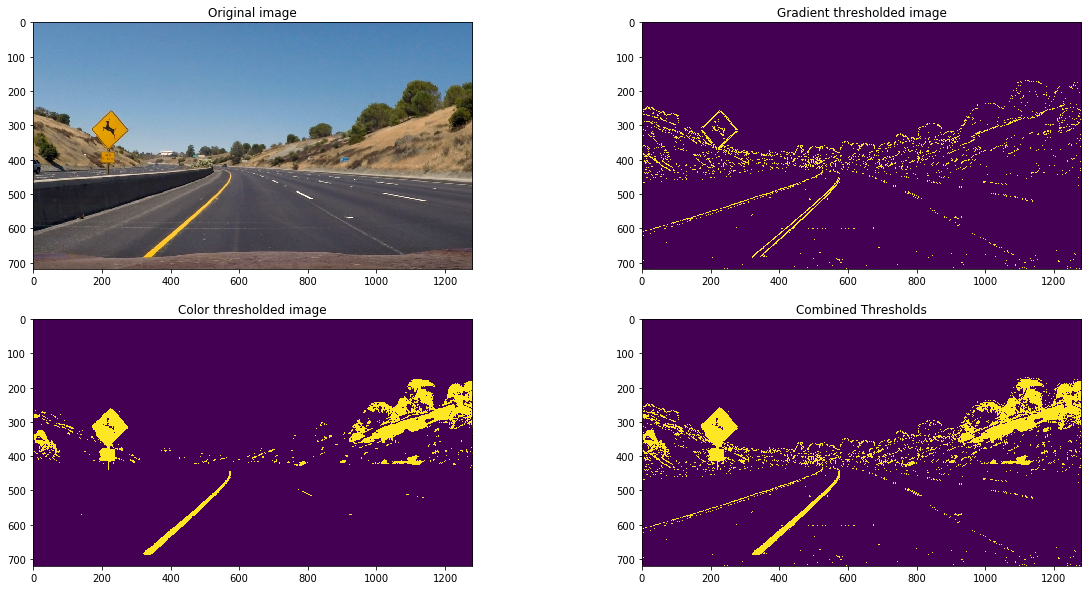

In [140]:
# Plotting thresholded images
# Make a list of test images
test_images = glob.glob('./test_images/*.jpg')
original_img = cv2.imread(test_images[3])
b,g,r = cv2.split(original_img)       # get b,g,r
original_img = cv2.merge([r,g,b])     # switch it to rgb
img_out = pipeline(original_img)
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.set_title('Original image')
ax1.imshow(original_img)
ax2.set_title('Gradient thresholded image')
ax2.imshow(img_out[:,:,0])
ax3.set_title('Color thresholded image')
ax3.imshow(img_out[:,:,1])
ax4.set_title('Combined Thresholds')
ax4.imshow(img_out[:,:,2])

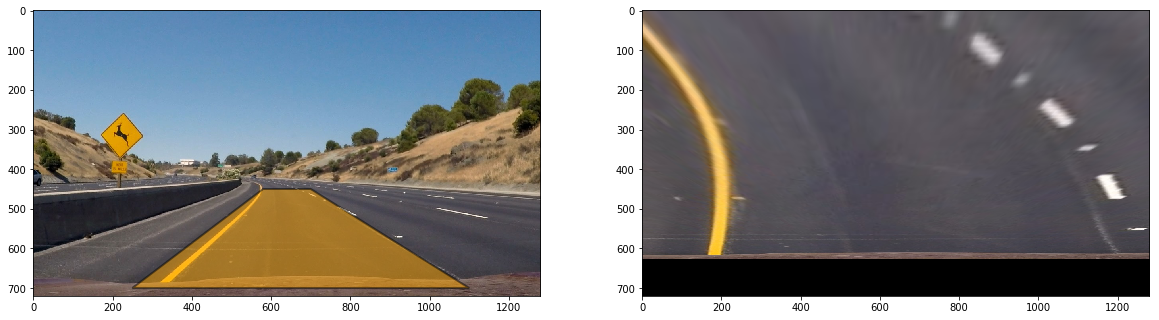

In [144]:
# My choice of 100 pixels is not exact, but close enough for our purpose here
offset = 100 # offset for dst points
# Grab the image shape
img_size = (original_img.shape[1], original_img.shape[0])

# For source points I'm grabbing the outer four detected corners
src = [(580.,450.), (700.,450.), (1100., 700.), (250., 700.),(0.,0.)]

from matplotlib.path import Path
import matplotlib.patches as patches

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY,
         ]

path = Path(src, codes)

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(original_img)
patch = patches.PathPatch(path, facecolor='orange', lw=2, alpha=0.5)
ax1.add_patch(patch)

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]-offset], 
                   [offset, img_size[1]-offset]])
src_pts = np.asarray(src[:-1],dtype=np.float32)
M = cv2.getPerspectiveTransform(src_pts, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(original_img, M, img_size)
ax2.imshow(warped)
plt.show()

(720, 1280, 3)
[(191.0, 1173.0), (190.0, 1180.0), (202.0, 1248.0), (204.0, 1180.0), (191.0, 1120.0), (166.0, 1047.0), (123.0, 1031.0), (69.0, 983.0), (24.0, 883.0)]
(array([640, 640, 640, ..., 719, 719, 719]), array([166, 167, 168, ..., 213, 214, 215]))
(array([560, 560, 560, ..., 639, 639, 639]), array([165, 166, 167, ..., 212, 213, 214]))
(array([480, 480, 480, ..., 559, 559, 559]), array([177, 178, 179, ..., 224, 225, 226]))
(array([400, 400, 400, ..., 479, 479, 479]), array([179, 180, 181, ..., 226, 227, 228]))
(array([320, 320, 320, ..., 399, 399, 399]), array([166, 167, 168, ..., 213, 214, 215]))
(array([240, 240, 240, ..., 319, 319, 319]), array([141, 142, 143, ..., 188, 189, 190]))
(array([160, 160, 160, ..., 239, 239, 239]), array([ 98,  99, 100, ..., 145, 146, 147]))
(array([ 80,  80,  80, ..., 159, 159, 159]), array([44, 45, 46, ..., 91, 92, 93]))
(array([ 0,  0,  0, ..., 79, 79, 79]), array([ 0,  1,  2, ..., 46, 47, 48]))


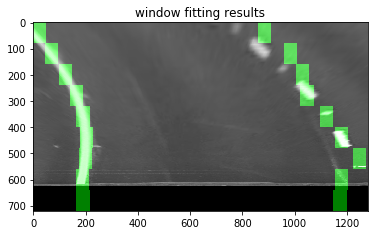

(720, 1280, 3)
(array([  0,   0,   0, ..., 719, 719, 719]), array([   0,    0,    0, ..., 1195, 1196, 1197]), array([0, 1, 2, ..., 1, 1, 1]))


In [145]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

print(warped.shape)
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1])) 
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids
img_gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
window_centroids = find_window_centroids(img_gray, window_width, window_height, margin)
print(window_centroids)
# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img_gray)
    r_points = np.zeros_like(img_gray)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img_gray,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img_gray,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
        print(l_mask.nonzero())
    
    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((img_gray,img_gray,img_gray)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((img_gray,img_gray,img_gray)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

pts = output.nonzero()
print(output.shape)
print(pts)